# Exploring Airbnb Data in Amsterdam

___
Data was collected from [InsideAirbnb](http://insideairbnb.com/) as of March 9th, 2023.

As stated on their 'about' page, "Inside Airbnb is a mission driven project that provides data and advocacy about Airbnb's impact on residential communities". This data is openly provided, allowing the general public, local governments, advocacy groups, and more to examine the impact Airbnb has on their communities. 

This notebook was created to explore the data in Amsterdam, and to demonstrate some of the capabilities of python for spatial data analytics. 

In [1]:
# Import all neccessary libraries
import pandas as pd # Tabular data manipulation
import matplotlib.pyplot as plt # Graphics
import seaborn as sns # Graphics
import geopandas as gpd # Spatial data manipulation
import folium # Interactive Mapping
from wordcloud import WordCloud # Wordcloud Graphics
import contextily  # Background Tiles
from pysal.lib import weights  # Spatial weights
from pysal.explore import esda  # Exploratory Spatial analytics
from splot import esda as esdaplot # Exploratory spatial data analysis

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Library/Frameworks/Python.framework/

## Non-Spatial Data Analysis

___

### Loading & Cleaning the Data

Our analysis commences by importing the dataset and performing necessary data cleaning procedures. It is worth noting that the data obtained from Inside Airbnb categorizes Airbnb listings by "neighbourhood". However, it is important to acknowledge that their classification of "neighbourhoods" aligns more closely with subdivisions within Amsterdam's boroughs. In subsequent stages of our spatial analysis, we will be utilizing data that represents the actual neighbourhoods of Amsterdam, which are smaller in size. Consequently, we will temporarily rename Inside Airbnb's "neighbourhoods" to "borough" to provide a more precise description of their content.

*Note: In this analysis, the term "borough" will be used to describe the subdivisions of Amsterdams boroughs/districts as provided by InsideAirbnb.*

In [2]:
# Read in the listing data
listings_df = pd.read_csv("data/listings.csv")
listings_df.rename(columns={"neighbourhood": "borough"}, inplace=True) # Change "neighbourhood" to borough to better reflect data
listings_df.drop(columns=["neighbourhood_group", "minimum_nights", "number_of_reviews", 
                 "last_review", "reviews_per_month", "calculated_host_listings_count", 
                 "availability_365", "number_of_reviews_ltm"], inplace=True) # Remove unnecessary data columns.
listings_df.head()

,id,name,host_id,host_name,borough,latitude,longitude,room_type,price,license
0,2818,Quiet Garden View Room & Super Fast Wi-Fi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.36435,4.94358,Private room,69,0363 5F3A 5684 6750 D14D
1,20168,Studio with private bathroom in the centre 1,59484,Alexander,Centrum-Oost,52.36407,4.89393,Private room,106,0363 CBB3 2C10 0C2A 1E29
2,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,Centrum-West,52.38761,4.89188,Private room,143,0363 974D 4986 7411 88D8
3,28871,Comfortable double room,124245,Edwin,Centrum-West,52.36775,4.89092,Private room,76,0363 607B EA74 0BD8 2F6F
4,29051,Comfortable single room,124245,Edwin,Centrum-Oost,52.36584,4.89111,Private room,56,0363 607B EA74 0BD8 2F6F


### Exploring the data

We can use Python with it's numerous data science visualization libraries such as seaborn/matplotlib (alongside pandas) to explore the data provided. 

For example, we can begin by identifying the hosts who possess the highest number of listings in the area.

In [3]:
# Count the number of times each host ID number appears, then remove extra data
host_id_counts = listings_df.value_counts("host_id").head(10) # Only check the top 10 hosts
list_sing_ids = listings_df.drop_duplicates('host_id')

print("TOP AMSTERDAM HOSTS BY LISTING COUNT\n")

# Iterate through the count data, and find the host names from amongst the reduced listings dataframe
for index, value in host_id_counts.items():
    host_name = list_sing_ids.loc[listings_df['host_id'] == index]["host_name"].item()
    print(f"Host: {host_name} | {value} listings.")

TOP AMSTERDAM HOSTS BY LISTING COUNT

Host: Sweets | 22 listings.
Host: Hotel Not Hotel | 20 listings.
Host: Arnold | 16 listings.
Host: Wittenberg | 14 listings.
Host: Abdullah | 14 listings.
Host: Remco | 12 listings.
Host: ClinkNOORD | 12 listings.
Host: Bunk | 12 listings.
Host: Neal Estate | 10 listings.
Host: Henk | 10 listings.


___
It wouldn't make sense to compare the cost of private rooms vs entire houses, so we can create subsets of our data, such as listings that are private rooms, to get further insights. 

One way of understanding the prices of the listings per borough is by creating a boxplot. As we can see below, although most listings fall within certain ranges, there are multiple (very expensive) outliers. I am tempted to manually check these private rooms to understand why they cost so far above the average, but for now that is outside the scope of this exploration.

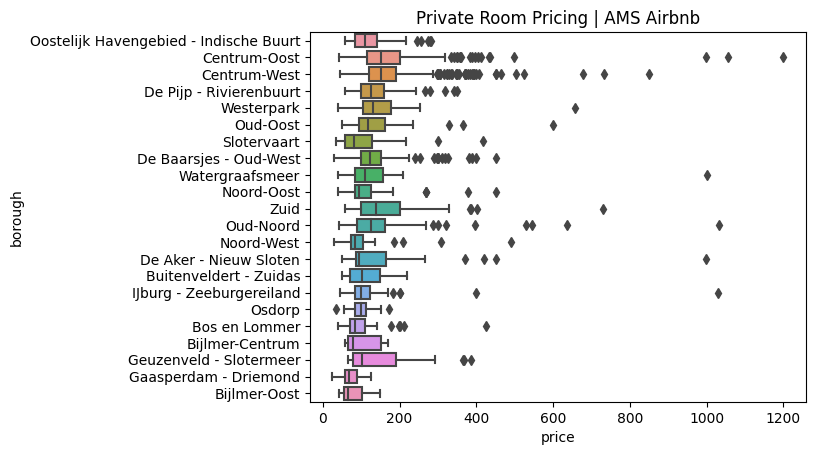

In [4]:
subset = listings_df.loc[listings_df['room_type'].isin(["Private room"])]
sns.boxplot(x='price', y='borough', data=subset).set_title("Private Room Pricing | AMS Airbnb")
plt.show()

___
We can even create a beautiful looking wordcloud from the names of the Airbnb Listings. Although we can't extract much useful information from this plot, it is still aesthetically pleasing and funny to see all the different ways people are spelling "apartment". If we wanted to more closely analyse this data, we can just as easily create a barplot.

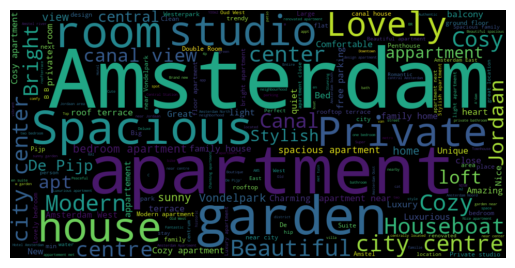

In [5]:
text = ""
for name in listings_df['name']: # Collect all listing names into single string
    text += " " + name

# Create the wordcloud object
wordcloud = WordCloud(width=960, height=480).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Spatial Data Analysis
___
### Basic Plotting

Plotting according to borough (as seen below) allows us to see the listings, alongside the outlines of the borough. Later on we'll be using a neighbourhood geojson file to conduct more in-depth spatial analysis.

[]

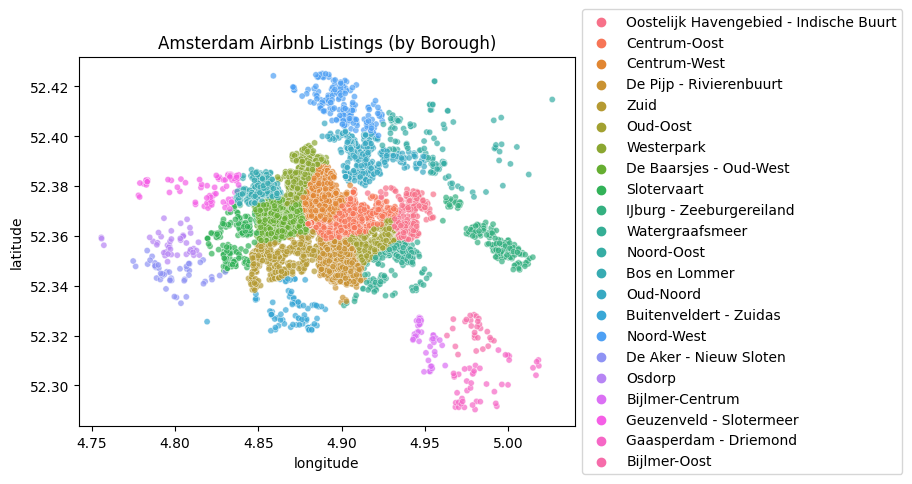

In [6]:
borough_scatter = sns.scatterplot(x='longitude', y='latitude', hue='borough', 
                          alpha=0.7, s=20, data=listings_df)
borough_scatter.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
borough_scatter.set_title("Amsterdam Airbnb Listings (by Borough)")
borough_scatter.plot()

___
From the previous plot, it is evident there are far too many listings/points overlapping for us to clearly see what is happening. To see the density of listings and find spatial patterns, we can use seaborns kdeplot (kernel density plot). From the seaborn documentation, "a kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset". 

To get a better sense (context) of the area, I have included an image of a map of Amsterdam for the background. Later on, we will be using a different tool for setting the basemap of the plots. This demonstrates the variaty of ways we can display spatial data and its surrounding context.

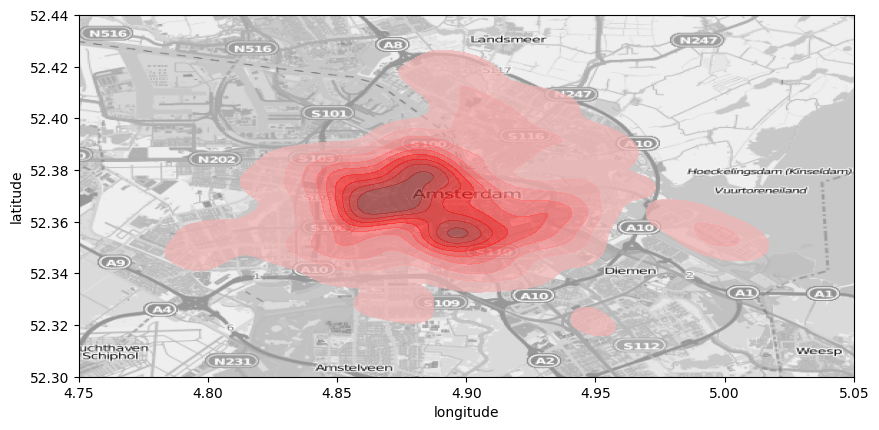

In [7]:
plt.figure(figsize=(10,8))

map_img = plt.imread("data/amsterdam.png") # Load image of Amsterdam

# Scale the image based on its lat/long to align it to the data
plt.imshow(map_img,zorder=0,extent=[4.699, 5.125, 52.247, 52.496]) 

# Create the kernel density estimate plot
sns.kdeplot(
    data=listings_df, x="longitude", y="latitude", fill=True, alpha=0.7, color="red"
)

plt.axis([4.75, 5.05, 52.30, 52.44])
plt.show()

___
Now that we're starting to understand how the listings are located in the context of the city, we can load in our borough spatial data (also provided by Inside Airbnb).

In [8]:
boroughs_gdf = gpd.read_file('data/boroughs.geojson') 
boroughs_gdf.rename(columns={"neighbourhood": "borough"}, inplace=True) # Change "neighbourhood" to borough to better reflect data
boroughs_gdf.crs # We can see that our GCS is WGS84, so we will change it to a projected system for the Netherlands.

<Geographic 3D CRS: EPSG:4979>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
boroughs_gdf = boroughs_gdf.to_crs(epsg=28992) # Transform geometries to Amersfoort / RD New
boroughs_gdf.crs

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'Sub-Boroughs of Amsterdam')

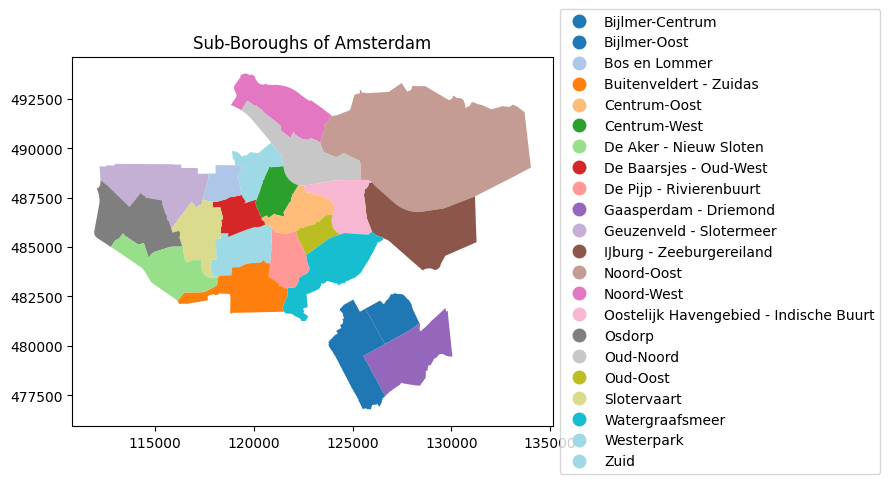

In [10]:
# A quick and easy way of looking at our spatial borough data
boroughs_gdf.plot(column = "borough", legend=True, cmap='tab20', 
                  legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5), 'ncol': 1}).set_title("Sub-Boroughs of Amsterdam")

___
We can also convert our previous listings dataframe into a geodataframe to continue our spatial analysis.
Originally the crs is set to WGS84 (as the data is in lat/long) but then I project it to our Amersfoort / RD New crs to match the rest of our data.

In [11]:
listings_gdf = gpd.GeoDataFrame(
    listings_df, geometry=gpd.points_from_xy(listings_df.longitude, listings_df.latitude), crs="EPSG:4231" 
).to_crs(epsg=28992)

___
By combining our borough geojson data with our newly created listing geodataframe, through the power of Folium we are able to create an interactive map of the data. This interactive map is fairly simply, just showing the borough name and average Airbnb rental price when you hover over a borough, but it demonstrates the power of Python for creating interative mapping software. On [my portfolio](https://juaneslamilla.github.io), you can see a past project where I harnessed the power of folium (alongside streamlit) to create an online interactive "mall-navigation" dashboard.

In [12]:
# Group listings by borough, and get the average of their values.
listings_by_borough = listings_gdf.groupby('borough').mean(numeric_only=True) 

# Round prices to 2 decimal places
listings_by_borough.price = listings_by_borough.price.round(2)

# Merge the listings and borough geodataframes
bor_lis_gdf = pd.merge(boroughs_gdf, listings_by_borough, on="borough")

# Plot an interactice map of the data
data_map = folium.Map(location=[52.377956, 4.897070], zoom_start=11)
folium.GeoJson(bor_lis_gdf, name="geojson",
                tooltip=folium.features.GeoJsonTooltip(
                    fields=['borough', 'price'],
                    aliases=['Borough name:', 'Average price'],
                )
              ).add_to(data_map)
data_map

___
## Local Spatial Autocorrelation

Now we're getting to the meat of the project. By incorporating the tools we've already used with new ones, we're able to explore some more complex spatial statistical concepts. This section follows the techniques given by "Geographic Data Science with Python" (2023) written by Dani Arribas-Bel and Levi John Wolf.

Normally, I would complete this sort of analysis in [GeoDa](http://geodacenter.github.io/). But by understanding how to do this in Python, I've given myself another tool for my metaphorical geospatial analysis toolbox. If I ever need to do this type of analysis on many different cities all at once, it is now easy work to automate the process.

I'll begin by loading in Amsterdam neighbourhood geographic data (collected from [here](https://github.com/blackmad/neighborhoods)).

In [13]:
neighbourhoods_gdf = gpd.read_file('data/neighbourhoods.geojson').to_crs(epsg=28992) # WGS84 Latitude/Longitude

By using the following code, we are able to assign Airbnb price averages to each of the neighbourhoods geographic polygons.

In [14]:
# Using a spatial join, assign the neighbourhood name to all listing points "within" the neighbourhood
sjoin_lis_ngbh = listings_gdf.sjoin(neighbourhoods_gdf, how="left", predicate="within")

# Group the listings by neighbourhood, and find the average prices
grouped_ngbh_lis = sjoin_lis_ngbh.groupby('name_right').mean(numeric_only=True)

# Merge the neighbourhood geodataframe with the new grouped listing data. 
# In essense, attaching the listings information to the respective neighbourhood geography.
lis_ngbh_gdf = pd.merge(neighbourhoods_gdf, grouped_ngbh_lis, left_on="name", right_on="name_right")

We can visualize our new combined geodataframe by creating a choropleth map of the average listing prices by neighbourhood.

Notice in this map we're using contextily to add a basemap of Amsterdam for surrounding spatial context.

Text(0.5, 1.0, 'AMS Airbnb Avg. Listing Price Per Neighbourhood (€)')

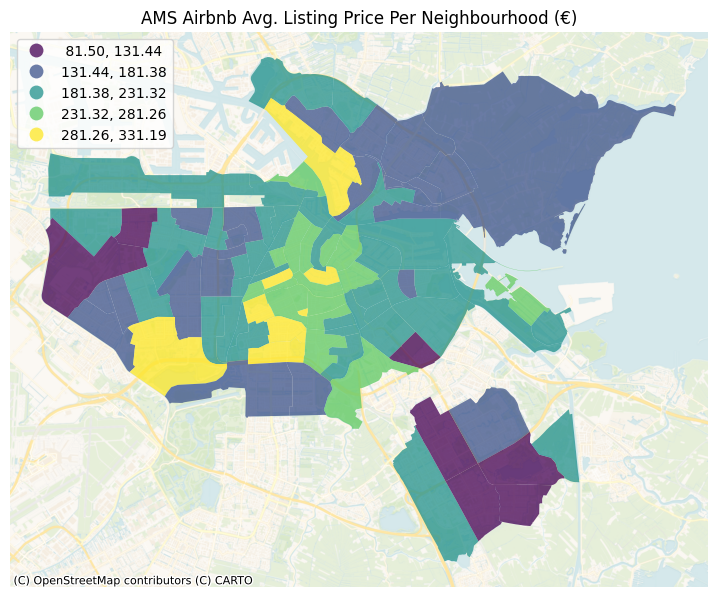

In [15]:
#Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
lis_ngbh_gdf.plot(
    column="price",
    cmap="viridis",
    scheme="EqualInterval", # Equal intervals was chosen to best determine low/high cost areas.
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=lis_ngbh_gdf.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off();
ax.set_title("AMS Airbnb Avg. Listing Price Per Neighbourhood (€)")

___

### Spatial Weights Matrix
For this local spatial autocorrelation analysis, I've decided to create a spatial weights matrix based on rook contiguity. Although there are disconnected components (as the Amsterdam boroughs, and thus the neighbourhoods, aren't completely connected), I believe the rook contiguity makes the most sense for this project for 2 reasons:
1. Due to the odd shape of some neighbourhoods, they may be more socially interconnected with their spatially connected neighbours than ones that are spatially closers (such as what occurs during the k-nearest neighbors algorithm).
2. Connecting the disconnected neighbourhoods by spatial proximity does not make sense as they have spatial barriers dividing them. Allowing these neighbourhoods to attach to just their spatial neighbours makes more intuitive sense for this analysis.

*Note: By creating a rook contiguity weights matrix with disconnected compenents, Python will throw a warning. This is fully expected.*

In [16]:
# Generate W from the GeoDataFrame
w = weights.Rook.from_dataframe(lis_ngbh_gdf)
# Row-standardization
w.transform = "R"

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


### Local Moran's I Scatterplot

Local Moran's I is our chosen method of computing spatial autocorrelation. Local Moran's I is a type of "local indicator of spatial association" (LISA) based on the Moran's I statistic. We could also compute a Global Moran's I, but for now that is outside of the scope of this project.


In order to compute the Local Moran's I values for each of our neighbourhoods, we must first find the spatial lag of the listing price averages alongside their respective centered versions.

The resulting scatterplot will have 4 quadrants. I've labelled them HH, HL, LH, LL which stands for High-High, High-Low, Low-High, and Low-Low respectively. In essense, a **High-High (HH)** neighbourhood has **high** average Airbnb prices and is surrounded by other neighbourhoods with **high** average Airbnb prices. A **High-Low (HL)** neighbourhood has **high** average Airbnb prices but is surrounded by neighbourhoods with **low** average Airbnb prices. And so on for LH and LL. 

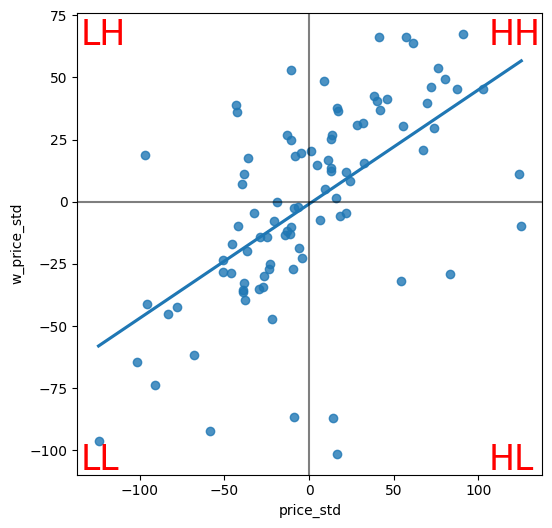

In [35]:
# Compute spatial lag of listing price averages
lis_ngbh_gdf["w_price"] = weights.lag_spatial(w, lis_ngbh_gdf['price'])

# Compute centered price averages (standardized according to mean)
lis_ngbh_gdf["price_std"] = lis_ngbh_gdf["price"] - lis_ngbh_gdf["price"].mean()
lis_ngbh_gdf["w_price_std"] = weights.lag_spatial(w, lis_ngbh_gdf['price_std'])


# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x="price_std", y="w_price_std", data=lis_ngbh_gdf, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(106, 63, "HH", fontsize=25, c="r")
plt.text(106, -108, "HL", fontsize=25, c="r")
plt.text(-135, 63, "LH", fontsize=25, c="r")
plt.text(-135, -108, "LL", fontsize=25, c="r")
# Display
plt.show()

___
We can begin to understand the distribution of the local spatial autocorrelation statistics by (once again) creating a kernel density estimate plot using seaborn. This plot tells if there is a skew towards there being local spatial autocorrelation, or not. The large hump around the 0 on the x-axis indicates randomness in the spatial relationship between neighbourhood prices. The tail towards the right indicates the spatial autocorrelation between "like" groups (HH, LL), while the tail towards the left indicates the spatial autocorrelation between "unlike" groups (HL, LH).

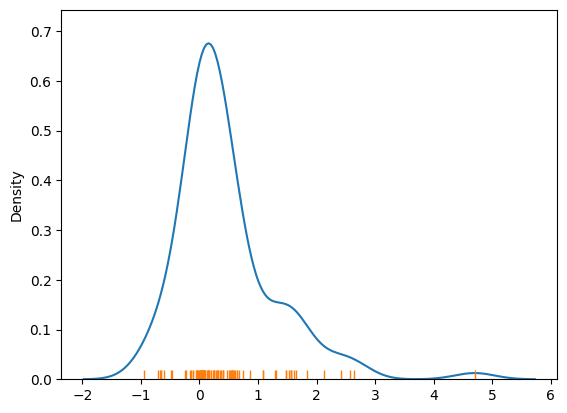

In [18]:
# Calculate Local Moran's I statistics using the ESDA (Exploratory Spatial Data Analysis) library
lisa = esda.moran.Moran_Local(lis_ngbh_gdf["price"], w)

# Draw KDE line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax);

___
Finally, we can create our LISA maps. Seeing whether or not there is spatial association between neighbouring neighbourhoods is not enough, we also need to determine whether or not it is statistically significant. The lisa variable we calculated using the ESDA library contains p-values, and so we must also check whether or not they are above 0.05 for each neighbourhood. The following code calculates which areas are statistically spatially autocorrelated, and maps accordingly.

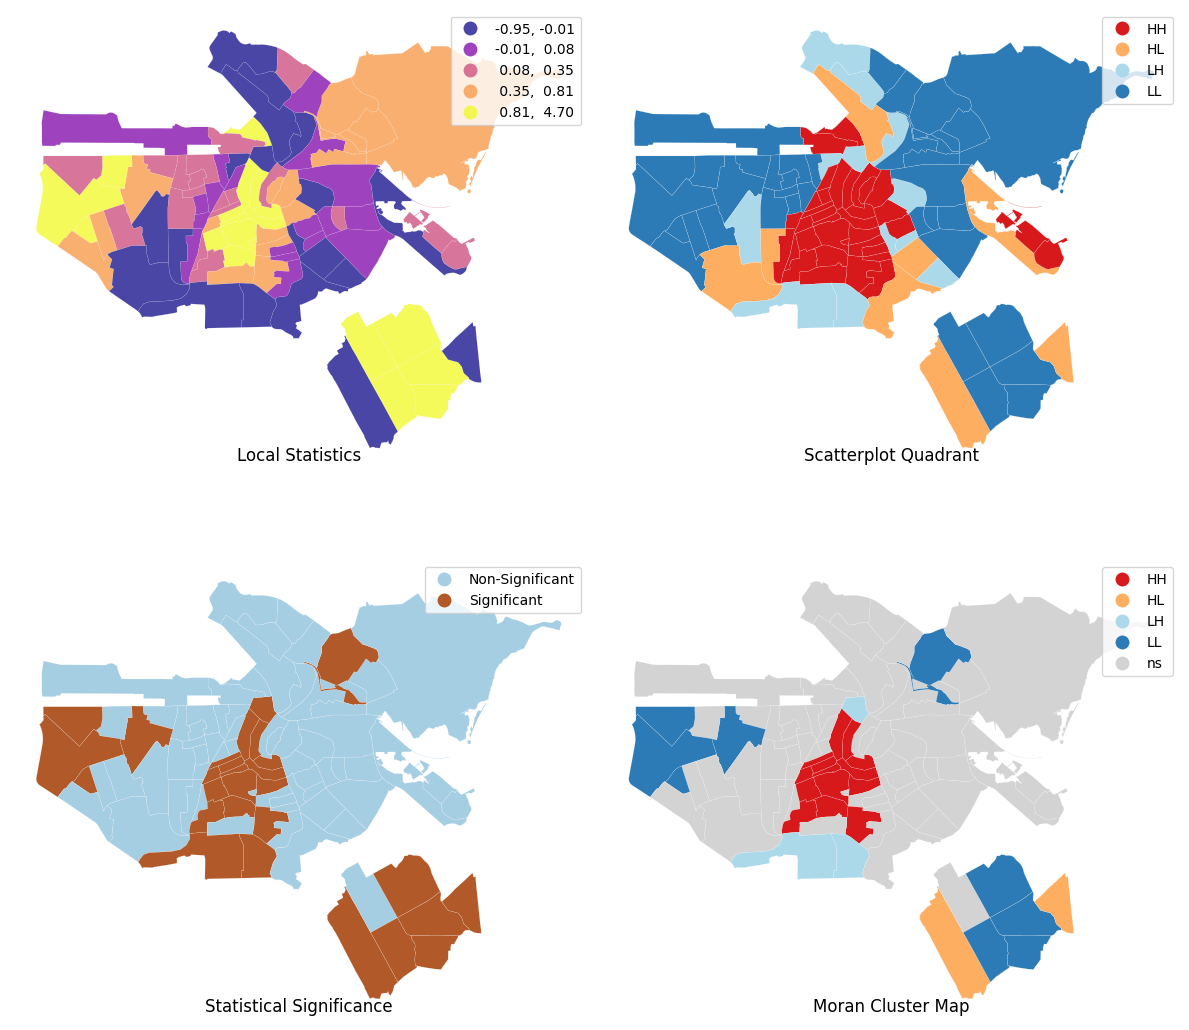

In [19]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
lis_ngbh_gdf.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, lis_ngbh_gdf, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=lis_ngbh_gdf.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
lis_ngbh_gdf.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, lis_ngbh_gdf, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

The above graphs show which neighbourhoods are spatially autocorrelated, but also shows which of these values are actually statistically significant. The "Moran Cluster Map" is arguably the most important of the 4, as it greys out the non-significant neighbourhoods, and leaves us with the significant ones to analyze.

As expected, there is a cluster of HH neighbourhoods in the city center. This is a popular tourist area, so it is expected that all of these neighbourhoods have expensive Airbnb listings. Similarly, there are some LL clusters on the outskirts of the city. These are likely less popular destinations for tourists, with lower demand for Airbnbs. The more interesting areas are the LH and HL's neighbourhoods. For example, the 2 neighbourhoods just south of the city center are both LH. Despite being relatively close to the popular tourist spots, they are seperated by a highway, thus greatly reducing their marketability. In the disconnected section to the south-east of the city there are 2 HL neighbourhoods in an otherwise LL area. Upon closer inspection via satellite imagery, we can see that the HL areas are primarily commercial and office space surrounded by suburban land (LL).
___
Seeing the map is great for finding visual patterns, but we should also find the names of the corresponding neighbourhoods. That is what the following code is for. After adding the Local Moran's I values to our geodataframe, we can print off the desired information.

In [20]:
# Assign pseudo P-values to `db`
lis_ngbh_gdf["p-sim"] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
lis_ngbh_gdf["sig"] = sig


# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
lis_ngbh_gdf["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=lis_ngbh_gdf.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)

# Print names of neighbourhoods that are statistically significantly spatially autocorrelated
lis_ngbh_gdf.loc[lis_ngbh_gdf['sig'] == 1][["name", "labels", "p-sim"]]

,name,labels,p-sim
2,Grachtengordel-West,HH,0.032
3,Grachtengordel-Zuid,HH,0.012
5,Haarlemmerbuurt,LH,0.004
6,Jordaan,HH,0.041
7,De Weteringschans,HH,0.002
18,Van Lennepbuurt,HH,0.025
19,Helmersbuurt,HH,0.013
20,Overtoomse Sluis,HH,0.008
21,Vondelbuurt,HH,0.001
30,Slotermeer-Zuidwest,LL,0.006


## Conclusion

Through this analysis, we were able to gain insights into the spatial patterns and relationships within the Amsterdam Airbnb dataset. The results shed light on the presence of significant local clusters or spatial outliers, providing valuable information about the spatial distribution of the listings data. 

If you would like to see more of my work or to get in touch, please visit [my personal website](http://juaneslamilla.github.io).